# Linear Models: VGG -> Linear Model -> Dog/Cat

## First, some config

Define paths:

In [1]:
%matplotlib inline
import os
path = '../../../data/dogscats/'
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

Set batch size (use largest that memory allows):

In [2]:
batch_size = 64

Start with VGG:

In [3]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

Using Theano backend.
/home/matt/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:01:00.0)


## Next, set up the actual model we'll use

VGG:
* Input: image, 244x244x3chan
* Output: first 1000 most likely tags from ImageNet

Linear Model:
* Input: 1000 labels from vgg
* Output: Cat/dog
* Train Against: Known label for VGG input image

### Initial Loading/Setup/Caching of Data:

In [4]:
from importlib import reload
import utils; reload(utils)
from utils import get_batches, get_data

In [5]:
batches = get_batches(path + 'train', shuffle=False, batch_size=1)
val_batches = get_batches(path + 'valid', shuffle=False, batch_size=1)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Let's use bcolz to save/load images as numpy arrays:

In [6]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [ ]:
trn_data = get_data(path + 'train')
val_data = get_data(path + 'valid')

In [ ]:
trn_data.shape

In [ ]:
save_array(model_path+'train_data.bc', trn_data)
save_array(model_path+'valid_data.bc', val_data)

### Future loading of preformatted data

In [7]:
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')

In [8]:
val_data.shape

(2000, 3, 224, 224)

### One-Hot Encoding

In [9]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [14]:
val_classes = val_batches.classes
trn_classes = batches.classes
# trn_classes[:100]

In [15]:
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)
# trn_labels[:100]

### Pass through VGG model

...and save them out using bcolz helpers we created

In [ ]:
trn_features = model.predict(trn_data, batch_size=batch_size, verbose=1)
val_features = model.predict(val_data, batch_size=batch_size, verbose=1)

In [ ]:
trn_features.shape

In [ ]:
save_array(model_path+'train_lastlayer_features.bc', trn_features)
save_array(model_path+'valid_lastlayer_features.bc', val_features)

In [10]:
trn_features = load_array(model_path+'train_lastlayer_features.bc')
val_features = load_array(model_path+'valid_lastlayer_features.bc')

### Train the Linear Model!

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop

Linear model with 2 outputs (dog or cat), 1000 inputs (labels from vgg)

In [12]:
batch_size = 100
lm = Sequential()
lm.add(Dense(2, activation='softmax', input_shape=(1000,)))
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
lm.fit(trn_features, trn_labels, epochs=3, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 0s - loss: 0.1026 - acc: 0.9643 - val_loss: 0.0858 - val_acc: 0.9670
Epoch 2/3
23000/23000 [==============================] - 0s - loss: 0.0776 - acc: 0.9735 - val_loss: 0.0916 - val_acc: 0.9705
Epoch 3/3
23000/23000 [==============================] - 0s - loss: 0.0758 - acc: 0.9766 - val_loss: 0.0946 - val_acc: 0.9705


In [17]:
lm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 2002      
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
_________________________________________________________________


## Let's check out the results!

### Start with Predictions + Probabilities

In [18]:
preds = lm.predict_classes(val_features, batch_size=batch_size)
probs = lm.predict_proba(val_features, batch_size=batch_size)[:,0]

 100/2000 [>.............................] - ETA: 0s

In [19]:
print(preds[:8])
print(probs[:8])

[0 0 0 0 0 0 0 0]
[ 1.      1.      1.      1.      1.      0.9938  1.      1.    ]


### Now get ready to inspect them

In [20]:
filenames = val_batches.filenames

In [21]:
n_view = 6 # how many images to look at at a time

In [22]:
from keras.preprocessing import image
from utils import plots
def plots_idx(idx, titles=None):
    plots([image.load_img(path+'valid/'+filenames[i]) for i in idx], titles=titles)

### Inspect Correct Predictions

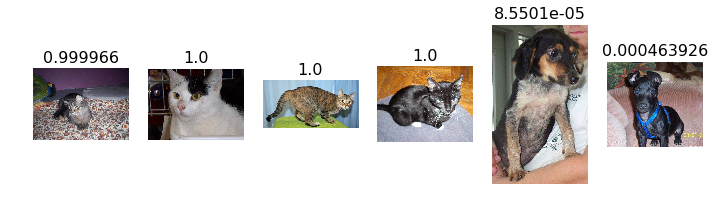

In [23]:
from numpy.random import permutation
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, titles=probs[idx])

### Inspect Incorrect Predictions

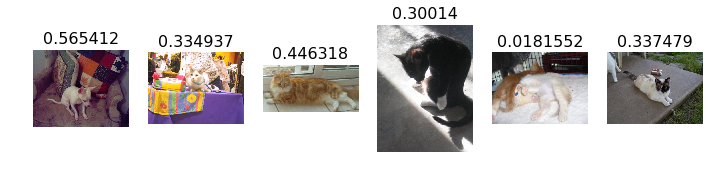

In [24]:
incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, titles=probs[idx])

### Inspect Incorrect Predictions By Class

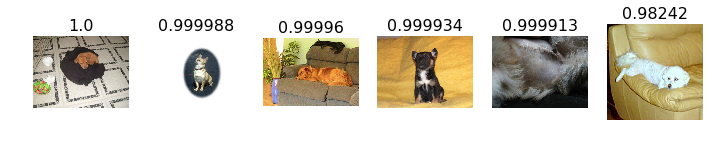

In [25]:
incorrect_cats = np.where((preds==0) & (preds!=val_labels[:,1]))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
if len(most_incorrect_cats):
    plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])
else:
    print('No incorrect cats!')

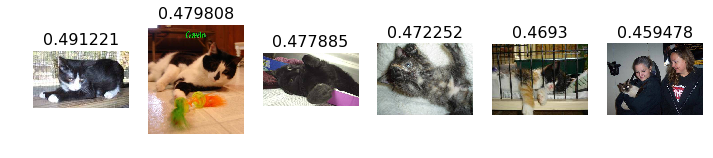

In [26]:
incorrect_dogs = np.where((preds==1) & (preds!=val_labels[:,1]))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[::-1][:n_view]
if len(most_incorrect_dogs):
    plots_idx(incorrect_dogs[most_incorrect_dogs], probs[incorrect_dogs][most_incorrect_dogs])
else:
    print('No incorrect dogs!')

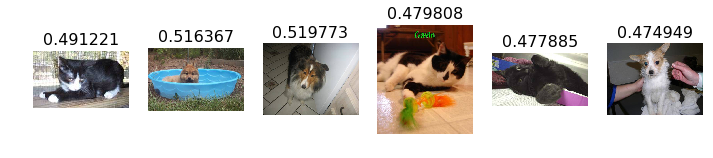

In [27]:
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

## Confusion Matrix!

[[965  35]
 [ 24 976]]


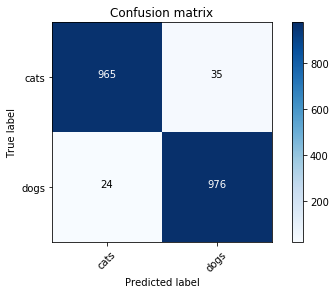

In [28]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, val_batches.class_indices)

## Testing + Submission to Kaggle

* Kaggle needs csv in format: id, prob(Dog)
* We have prob(Cat) right now, need to do prob(Dog) = 1-prob(Cat)

In [30]:
test_data = get_data(path + 'test-redux')

Found 12500 images belonging to 1 classes.


In [31]:
test_data.shape

(12500, 3, 224, 224)

## VGG labels from images

In [90]:
test_batches = get_batches(path + 'test-redux', shuffle=False, batch_size=1)

Found 12500 images belonging to 1 classes.


In [102]:
idx = [int(fn.split('/')[1].split('.')[0]) for fn in test_batches.filenames]

In [32]:
test_features = model.predict(test_data, batch_size=batch_size, verbose=1)

12500/12500 [==============================] - 50s    


### Linear model preds from VGG labels

In [33]:
test_preds = lm.predict_classes(test_features, batch_size=batch_size)
test_probs = lm.predict_proba(test_features, batch_size=batch_size)[:,0]

  100/12500 [..............................] - ETA: 0s

In [34]:
test_probs[:10]

array([  1.0000e+00,   2.2494e-04,   1.0000e+00,   1.5643e-03,   1.0000e+00,   9.3107e-03,
         1.4991e-04,   1.8795e-05,   2.5952e-05,   1.0000e+00], dtype=float32)

In [139]:
prob_dog = np.array(1-test_probs)
prob_dog

array([ 0.    ,  0.9998,  0.    , ...,  1.    ,  0.9993,  0.    ], dtype=float32)

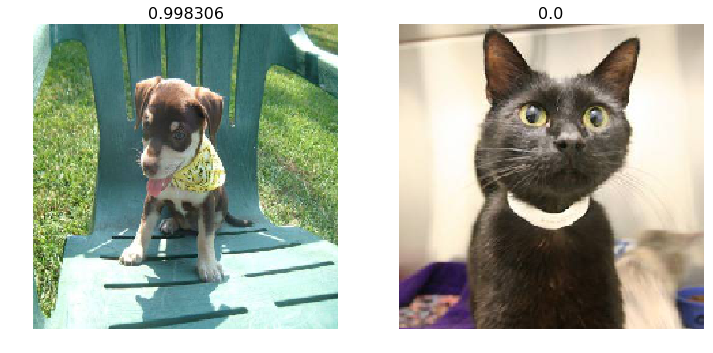

In [89]:
plots(test_data[12498:], titles=prob_dog[12489:])

### Prepare initial submission

Actually, the real initial submission had issues due to the way load_data pulls things in (alphabetically?) so I had to redo.

In [134]:
prob_dog_idx = np.c_[np.array(idx), prob_dog]
prob_dog_idx[:5]

array([[  3.4960e+03,   0.0000e+00],
       [  1.0203e+04,   9.9978e-01],
       [  1.9230e+03,   0.0000e+00],
       [  2.0560e+03,   9.9844e-01],
       [  8.5060e+03,   0.0000e+00]])

In [104]:
np.savetxt(path+"test-redux-preds.csv", prob_dog_idx,"%d,%f",header="id,label", comments="")

### Improvements?

Can optimize based on the fact they're scoring based on log loss. Log loss severely penalizes confident answers that are wrong. Because of this we can cheat in a bit by shaving off the massive spike on the incorrect side, and paying for it only slightly on the correct answers.

In [105]:
prob_dog = prob_dog.clip(min=0.025, max=0.975)

In [106]:
prob_dog_idx = np.c_[np.array(idx), prob_dog]
prob_dog_idx[:5]

array([[  3.4960e+03,   2.5000e-02],
       [  1.0203e+04,   9.7500e-01],
       [  1.9230e+03,   2.5000e-02],
       [  2.0560e+03,   9.7500e-01],
       [  8.5060e+03,   2.5000e-02]])

In [107]:
np.savetxt(path+"test-redux-preds.csv", prob_dog_idx,"%d,%f",header="id,label", comments="")

Cool. This worked and brought it down significantly. But where is the optimal cutoff?

<IPython.core.display.Javascript object>


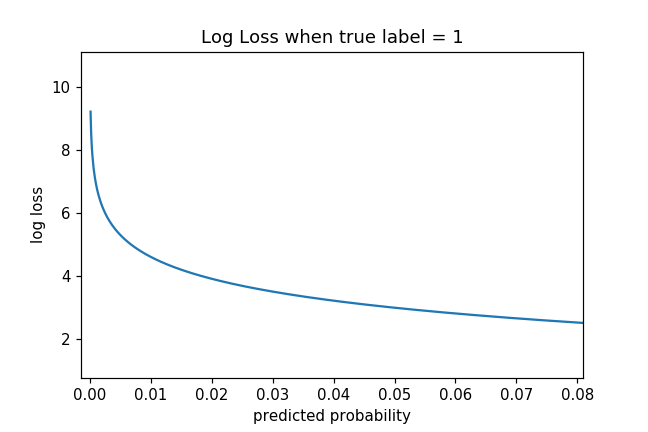

In [136]:
%matplotlib notebook
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt
x = np.linspace(0.0001, 1, 9999).tolist()
y = [log_loss([0],[[i*.0001,1-(i*.0001)]],eps=1e-15,labels=[0,1]) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

In [135]:
# 0.05 to 0.95 clip
prob_dog = prob_dog.clip(min=0.05, max=0.95)
prob_dog_idx = np.c_[np.array(idx), prob_dog]
prob_dog_idx[:5]
np.savetxt(path+"test-redux-preds.csv", prob_dog_idx,"%d,%f",header="id,label", comments="")

In [137]:
# 0.1 to 0.9 clip
prob_dog = prob_dog.clip(min=0.1, max=0.9)
prob_dog_idx = np.c_[np.array(idx), prob_dog]
prob_dog_idx[:5]
np.savetxt(path+"test-redux-preds.csv", prob_dog_idx,"%d,%f",header="id,label", comments="")

Results:

* 0.025 cutoff => 0.10402 log loss
* 0.05 cutoff => 0.12011 log loss
* 0.1 cutoff => 0.16126 log loss
* 0 cutoff => 0.18336 log loss

Try one more short of 0.025?

(**Note**: need to regenerate the original `prob_dog` first since we've already clipped beyond this)

In [140]:
# 0.02 to 0.98 clip
prob_dog = prob_dog.clip(min=0.02, max=0.98)
prob_dog_idx = np.c_[np.array(idx), prob_dog]
prob_dog_idx[:5]
np.savetxt(path+"test-redux-preds.csv", prob_dog_idx,"%d,%f",header="id,label", comments="")